In [1]:
import importlib

package_name = "datasets"

try:
    importlib.import_module(package_name)
    print(f"{package_name} is already installed.")
except ImportError:
    print(f"{package_name} is not installed. Installing it now...")
    !pip install {package_name}
    print(f"{package_name} has been successfully installed.")

c:\Users\Steven\anaconda3\envs\stock\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


datasets is already installed.


In [2]:
import importlib

package_name = "accelerate"

try:
    importlib.import_module(package_name)
    print(f"{package_name} is already installed.")
except ImportError:
    print(f"{package_name} is not installed. Installing it now...")
    !pip install {package_name}
    print(f"{package_name} has been successfully installed.")

accelerate is already installed.


In [1]:
import os
import shutil
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
from scipy.special import softmax
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

from transformers import Trainer
from transformers import TrainingArguments
from transformers import AutoModelForSequenceClassification
from transformers import AutoModelForPreTraining
from transformers import BertTokenizer, AutoTokenizer, DataCollatorWithPadding, BertForSequenceClassification

from datasets import load_metric
from datasets import load_dataset
from datasets import load_from_disk

import plotly.graph_objects as go

import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
from google.colab import drive
drive.mount("/content/drive")

%cd "/content/drive/MyDrive/6386"

# from colab.file_utils import load_required
# load_required(force_reinstall_pytorch=True)

ModuleNotFoundError: No module named 'google.colab'

In [7]:
import torch
torch.cuda.empty_cache()

In [8]:
print(os.getcwd())

d:\Cornell\course\CS6386\Analyzing-the-Correlation-Between-Retail-Traders--Sentiments-and-Equity-Market-Movements\Sentiment_Analysis


In [9]:
saved_model_dir = "saved_model"

# Check if the saved_model_dir exists
if os.path.exists(saved_model_dir):
    # If it exists, remove its contents recursively
    shutil.rmtree(saved_model_dir)

In [ ]:
# !pip install datasets

In [ ]:
# # Hugging Face pre-trained
# tokenizer = AutoTokenizer.from_pretrained("nlpaueb/sec-bert-base")
# model = AutoModelForPreTraining.from_pretrained("nlpaueb/sec-bert-base")

In [10]:
# checkpoint = "bert-base-uncased"
checkpoint = "bert-base-cased"
# checkpoint = "distilbert-base-uncased"
# model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=2)
model = BertForSequenceClassification.from_pretrained(checkpoint, num_labels=2).to(device)

tokenizer = AutoTokenizer.from_pretrained(checkpoint)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [11]:
raw_datasets = load_from_disk("data/finetune_data")
# raw_datasets = load_from_disk("finetune_data")

def tokenize_function(example):
    return tokenizer(example["text"], padding=True, truncation=True)

tokenized_datasets = raw_datasets.map(tokenize_function, batched=True)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer) # pad all the examples to the length of the longest element when we batch elements together — dynamic padding.

Map: 100%|██████████| 876/876 [00:00<00:00, 6580.61 examples/s]


In [12]:
tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 8925
    })
    validation: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 2232
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 876
    })
})

In [13]:
tokenized_datasets['test']['label'][:10]

[1, 0, 1, 1, 1, 1, 1, 0, 0, 0]

In [14]:
tokenized_datasets['train']['text'][:10]

["$SQ's stock price faces downward pressure amid increased competition in digital payments.",
 'FS Nice Breakout w volume. Next resistance lies at 33.38  ',
 'The six breweries recorded a 5.2 percent growth in domestic beer sales last year to 270.21 million liters , from 256.88 million liters sold in 2005 .',
 'user: CBMX long 4.90 -4.95 play thru 5.00 again - selling half 5.20 raise stop on rest',
 'Government, RBI Try To Cushion An Economy In Slump Even Before COVID-19\r\nhttps://t.co/RqiEYHTYOV',
 'MDSO - ong  27.51. Trailing Stop  41.40 from 11 prior Stops of 38.58, 37.67, 37.11, ... 27.51, 25.15 and 22.79 -  ',
 'Shorting GM and TSA once again.  TSA At the high end short term over bought, channel continuation or right shoulder falling H&S...',
 'Sensex, Nifty Likely To Start Session Sharply Lower In Gap-Down Opening\r\nhttps://t.co/rrH5C0GMs5',
 'big freakin HT to myself as CEE was the ONY stock mentioned in  my Dec12 video as a breakout stock for 2013 :)',
 'Big fan of $BLK reall

In [15]:
metric = load_metric("glue", "mrpc")

def compute_metrics(eval_preds):
    logits, labels = eval_preds
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

C:\Users\Steven\AppData\Local\Temp\ipykernel_5688\3511302106.py:1: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("glue", "mrpc")


In [ ]:
# !pip install transformers[torch]
# !pip install accelerate -U

In [ ]:
import accelerate
print(accelerate.__version__)

0.24.1


In [17]:
training_args = TrainingArguments(
    output_dir="test-trainer",
    evaluation_strategy="epoch",
    num_train_epochs=10,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=256,
    # During the first 500 training steps, the learning rate gradually increases from 0 (or a small base rate) to the specified learning rate.
    # This gradual increase helps in stabilizing the training process and often leads to better performance, as it prevents the model from making too large updates too quickly.
    warmup_steps=200,
    weight_decay=0.01,
    logging_dir='logs',
    logging_steps=10,  # how frequently the training progress is logged
    save_strategy="epoch",  # Set save strategy to "epoch" to save both best and last models
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    report_to="none",  # disable wandb
    learning_rate=1e-4,
    # fp16=True,  # Enable mixed precision training
)

trainer = Trainer(
    model,
    training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

In [ ]:
trainer.train()

  0%|          | 0/5580 [00:00<?, ?it/s]

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


KeyboardInterrupt: 

In [ ]:
output_dir = "saved_model"
os.makedirs(output_dir, exist_ok=True)

# Save the best model and the last model
trainer.save_model(output_dir)
tokenizer.save_pretrained(output_dir)

('saved_model\\tokenizer_config.json',
 'saved_model\\special_tokens_map.json',
 'saved_model\\vocab.txt',
 'saved_model\\added_tokens.json',
 'saved_model\\tokenizer.json')

In [ ]:
predictions = trainer.predict(tokenized_datasets["test"])
print(predictions.predictions.shape, predictions.label_ids.shape)

IndexError: Target 2 is out of bounds.

In [ ]:
predictions

PredictionOutput(predictions=array([[ 2.9296482, -2.4611754],
       [ 2.930862 , -2.464403 ],
       [ 1.5338113, -2.3713057],
       ...,
       [ 2.9295638, -2.4609487],
       [-1.5164928,  2.3670745],
       [ 2.9285212, -2.4581392]], dtype=float32), label_ids=array([1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1,
       1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1,
       0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0,
       1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0,
       1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0,
       0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0,
    

In [ ]:
probabilities = softmax(predictions.predictions, axis=1)
predicted_labels = np.argmax(probabilities, axis=1)

print("Probabilities:\n", probabilities)
print("Predicted Labels:\n", predicted_labels)

Probabilities:
 [[0.9954625  0.00453754]
 [0.99548244 0.00451752]
 [0.98025894 0.01974104]
 ...
 [0.99546105 0.00453894]
 [0.0201624  0.9798376 ]
 [0.9954436  0.00455638]]
Predicted Labels:
 [0 0 0 1 1 0 1 0 0 0 0 1 1 0 0 1 1 1 1 1 1 0 1 1 1 1 1 0 1 0 0 1 1 1 0 0 1
 1 1 0 0 1 1 1 1 0 1 0 1 1 1 0 0 0 1 1 0 1 1 0 1 1 1 0 0 1 1 1 1 1 0 1 1 1
 0 1 0 1 0 1 0 1 0 1 1 1 0 1 1 1 1 1 1 1 0 1 1 1 1 0 1 0 1 0 1 1 1 0 0 0 1
 1 1 1 0 1 0 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 0 0 1 1 1 1 0 1
 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 0 1 1 0 0 0 1 1 1 1 0 1 1 0 0
 0 0 1 0 1 1 1 1 1 0 1 0 0 0 1 0 1 1 1 1 1 1 0 0 0 0 0 1 0 1 1 0 0 1 0 0 0
 0 1 1 1 0 1 1 1 0 1 1 1 1 1 1 1 1 0 1 0 1 0 0 0 1 0 0 0 1 0 0 1 1 0 1 1 1
 0 1 0 1 1 0 1 1 0 1 0 0 1 1 1 1 1 0 0 0 1 1 0 1 1 1 1 1 0 0 1 0 1 1 1 0 1
 1 1 0 1 1 1 1 0 0 0 0 1 1 1 1 1 1 0 0 1 0 0 0 1 1 0 1 1 0 1 1 1 0 1 1 1 1
 0 0 0 1 0 1 1 0 0 1 1 1 0 1 1 1 0 0 1 1 0 0 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1
 0 1 1 0 0 1 1 1 0 1 0 0 1 0 1 0 1 1 1 0 0 1 1 1 0 1 1 1 0 

In [23]:
true_labels = tokenized_datasets["test"]["label"]

accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels)
recall = recall_score(true_labels, predicted_labels, average='weighted')
f1 = f1_score(true_labels, predicted_labels, average='weighted')

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Accuracy: 0.7579908675799086
Precision: 0.7651006711409396
Recall: 0.7579908675799086
F1 Score: 0.7522090232665878


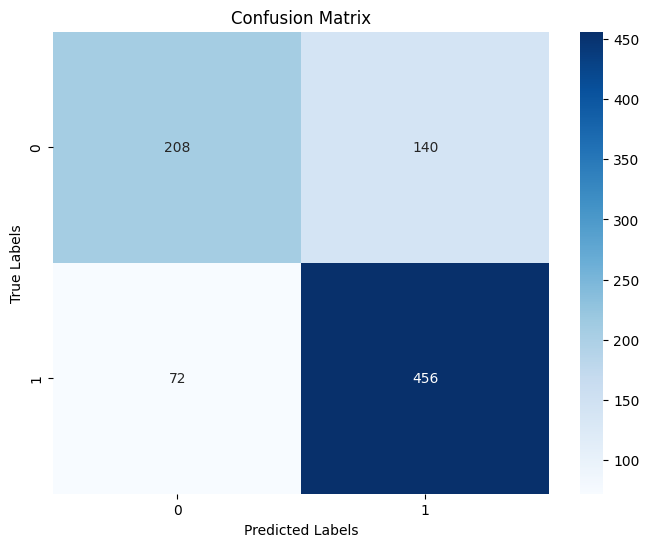

In [31]:
class_labels = ["0","1"]

# Compute the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Create a heatmap of the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [32]:
from sklearn.metrics import classification_report

# Generate a classification report
report = classification_report(true_labels, predicted_labels, target_names=class_labels)

# Print the classification report
print(report)

              precision    recall  f1-score   support

           0       0.74      0.60      0.66       348
           1       0.77      0.86      0.81       528

    accuracy                           0.76       876
   macro avg       0.75      0.73      0.74       876
weighted avg       0.76      0.76      0.75       876



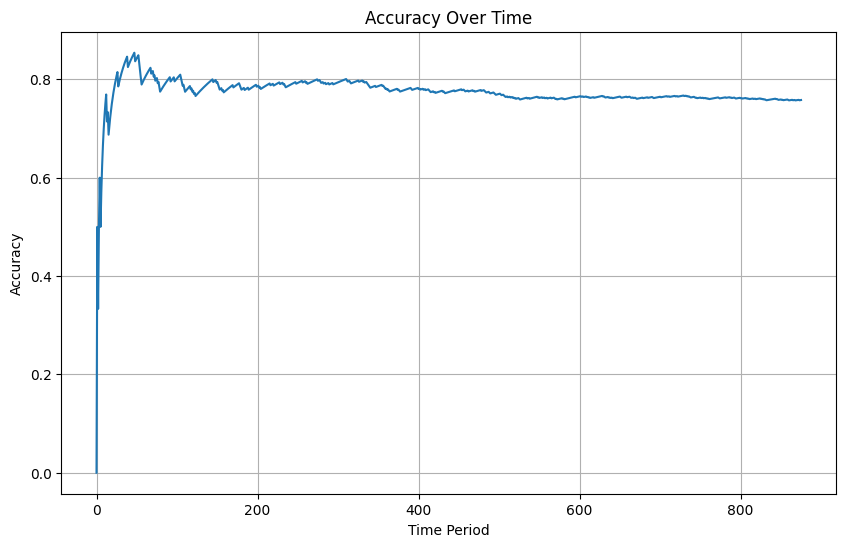

In [29]:
# import numpy as np

# # Create an array to represent time periods (e.g., days, months)
# time_periods = np.arange(len(true_labels))

# # Calculate accuracy at each time period
# accuracies = [np.mean(true_labels[:i+1] == predicted_labels[:i+1]) for i in range(len(true_labels))]

# # Create a line plot
# plt.figure(figsize=(10, 6))
# plt.plot(time_periods, accuracies)
# plt.xlabel('Time Period')
# plt.ylabel('Accuracy')
# plt.title('Accuracy Over Time')
# plt.grid(True)
# plt.show()


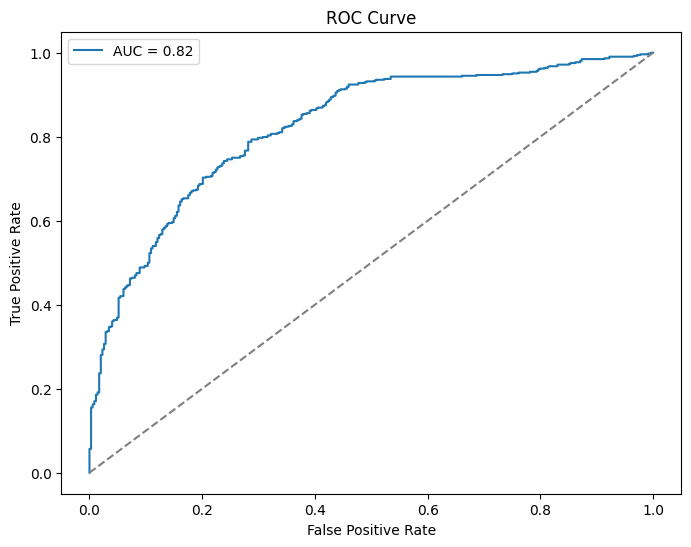

In [30]:
from sklearn.metrics import roc_curve, roc_auc_score

# Compute ROC curve
fpr, tpr, _ = roc_curve(true_labels, probabilities[:, 1])  # Assuming binary classification

# Calculate AUC (Area Under the Curve)
auc = roc_auc_score(true_labels, probabilities[:, 1])

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()


In [ ]:
# helper_model.print_wrong_classifications(predicted_labels, true_labels, raw_datasets['test'])

Use the saved model to predit on the unlabled testing data.

In [20]:
# Define the path to the saved model directory
saved_model_dir = "saved_model"

# Load the saved tokenizer
tokenizer = BertTokenizer.from_pretrained(saved_model_dir)

# Load the saved model
model = BertForSequenceClassification.from_pretrained(saved_model_dir)
model

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [22]:
trainer = Trainer(model=model)
predictions = trainer.predict(tokenized_datasets["test"])
# Apply softmax to convert logits to probabilities
probabilities = softmax(predictions.predictions, axis=1)

# Get the predicted class labels
predicted_labels = np.argmax(probabilities, axis=1)

print("Probabilities:\n", probabilities)
print("Predicted Labels:\n", predicted_labels)

100%|██████████| 110/110 [05:04<00:00,  2.77s/it]

Probabilities:
 [[0.9954625  0.00453753]
 [0.99548244 0.00451752]
 [0.98025906 0.01974093]
 ...
 [0.99546105 0.00453894]
 [0.0201624  0.9798376 ]
 [0.9954436  0.00455638]]
Predicted Labels:
 [0 0 0 1 1 0 1 0 0 0 0 1 1 0 0 1 1 1 1 1 1 0 1 1 1 1 1 0 1 0 0 1 1 1 0 0 1
 1 1 0 0 1 1 1 1 0 1 0 1 1 1 0 0 0 1 1 0 1 1 0 1 1 1 0 0 1 1 1 1 1 0 1 1 1
 0 1 0 1 0 1 0 1 0 1 1 1 0 1 1 1 1 1 1 1 0 1 1 1 1 0 1 0 1 0 1 1 1 0 0 0 1
 1 1 1 0 1 0 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 0 0 1 1 1 1 0 1
 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 0 1 1 0 0 0 1 1 1 1 0 1 1 0 0
 0 0 1 0 1 1 1 1 1 0 1 0 0 0 1 0 1 1 1 1 1 1 0 0 0 0 0 1 0 1 1 0 0 1 0 0 0
 0 1 1 1 0 1 1 1 0 1 1 1 1 1 1 1 1 0 1 0 1 0 0 0 1 0 0 0 1 0 0 1 1 0 1 1 1
 0 1 0 1 1 0 1 1 0 1 0 0 1 1 1 1 1 0 0 0 1 1 0 1 1 1 1 1 0 0 1 0 1 1 1 0 1
 1 1 0 1 1 1 1 0 0 0 0 1 1 1 1 1 1 0 0 1 0 0 0 1 1 0 1 1 0 1 1 1 0 1 1 1 1
 0 0 0 1 0 1 1 0 0 1 1 1 0 1 1 1 0 0 1 1 0 0 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1
 0 1 1 0 0 1 1 1 0 1 0 0 1 0 1 0 1 1 1 0 0 1 1 1 0 1 1 1 0 

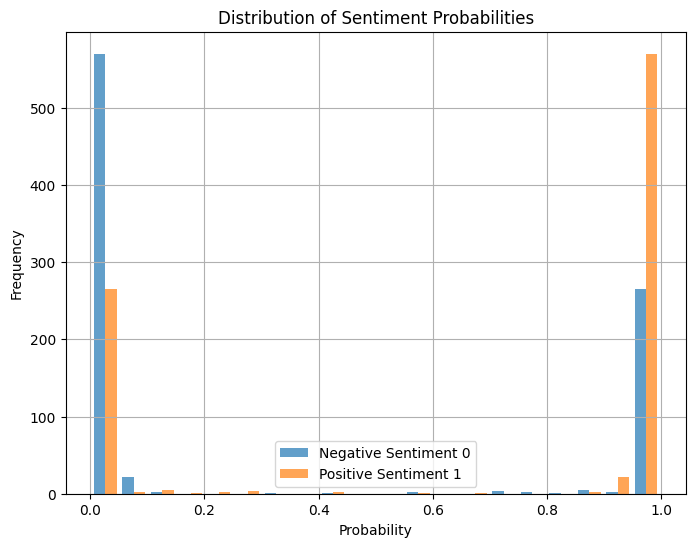

In [35]:
# Separate probabilities for sentiment 0 and sentiment 1
sentiment_0_probs = probabilities[:, 0]
sentiment_1_probs = probabilities[:, 1]

# Create a histogram or bar plot
plt.figure(figsize=(8, 6))
plt.hist([sentiment_0_probs, sentiment_1_probs], bins=20, label=['Negative Sentiment 0', 'Positive Sentiment 1'], alpha=0.7)
plt.xlabel('Probability')
plt.ylabel('Frequency')
plt.title('Distribution of Sentiment Probabilities')
plt.legend()
plt.grid(True)
plt.show()

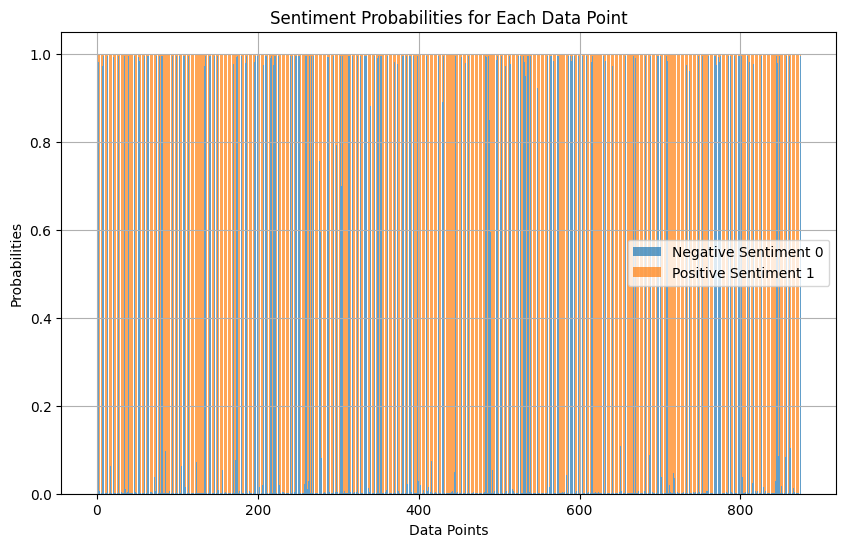

In [37]:
# Separate probabilities for sentiment 0 and sentiment 1
sentiment_0_probs = probabilities[:, 0]
sentiment_1_probs = probabilities[:, 1]

# Create a stacked bar plot
plt.figure(figsize=(10, 6))
indices = np.arange(len(probabilities))
plt.bar(indices, sentiment_0_probs, label='Negative Sentiment 0', alpha=0.7)
plt.bar(indices, sentiment_1_probs, bottom=sentiment_0_probs, label='Positive Sentiment 1', alpha=0.7)
plt.xlabel('Data Points')
plt.ylabel('Probabilities')
plt.title('Sentiment Probabilities for Each Data Point')
plt.legend()
plt.grid(True)
plt.show()

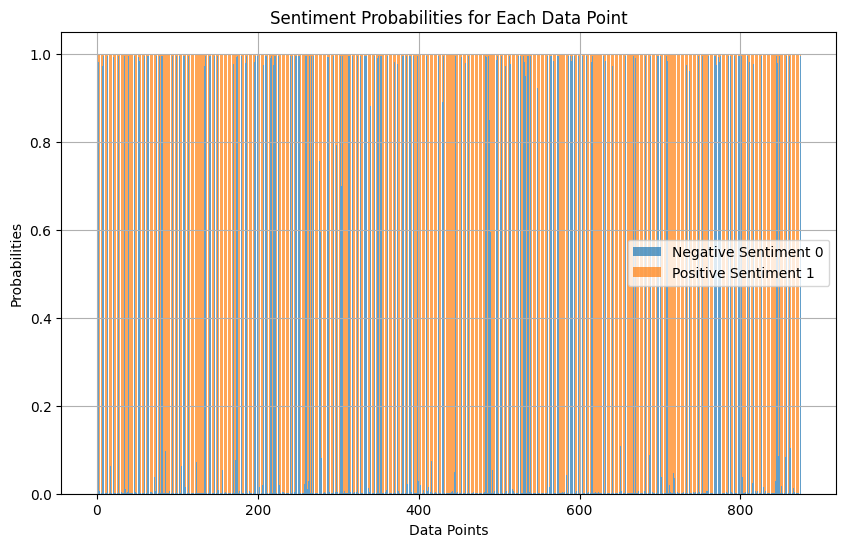

In [38]:
# Separate probabilities for sentiment 0 and sentiment 1
sentiment_0_probs = probabilities[:, 0]
sentiment_1_probs = probabilities[:, 1]

# Create a stacked bar plot with Negative Sentiment 0 on the left
plt.figure(figsize=(10, 6))
indices = np.arange(len(probabilities))
plt.bar(indices, sentiment_0_probs, label='Negative Sentiment 0', alpha=0.7)
plt.bar(indices, sentiment_1_probs, bottom=sentiment_0_probs, label='Positive Sentiment 1', alpha=0.7)
plt.xlabel('Data Points')
plt.ylabel('Probabilities')
plt.title('Sentiment Probabilities for Each Data Point')
plt.legend()
plt.grid(True)
plt.show()

In [39]:
# Separate probabilities for sentiment 0 and sentiment 1
sentiment_0_probs = probabilities[:, 0]
sentiment_1_probs = probabilities[:, 1]

# Create an interactive scatter plot
fig = go.Figure()

fig.add_trace(go.Scatter(x=np.arange(len(probabilities)), y=sentiment_0_probs, mode='markers', name='Sentiment 0', marker=dict(size=8)))
fig.add_trace(go.Scatter(x=np.arange(len(probabilities)), y=sentiment_1_probs, mode='markers', name='Sentiment 1', marker=dict(size=8)))

fig.update_layout(
    xaxis_title='Data Points',
    yaxis_title='Probabilities',
    title='Sentiment Probabilities for Each Data Point',
    xaxis=dict(type='linear', range=[0, len(probabilities)]),
    yaxis=dict(type='linear', range=[0, 1]),
    hovermode='x unified'
)

fig.update_xaxes(showgrid=True)
fig.update_yaxes(showgrid=True)

# Enable zooming and panning
fig.update_xaxes(fixedrange=False)
fig.update_yaxes(fixedrange=False)

# Show the interactive plot
fig.show()

NameError: name 'go' is not defined

In [ ]:
result_df = pd.DataFrame({
    'text': raw_datasets['test_unlabeled']['text'],
    'Predicted_Labels': predicted_labels,
    'Probability_Class_0': probabilities[:, 0],
    'Probability_Class_1': probabilities[:, 1], # 2 classes
})

output_csv_path = "predictions.csv"
result_df.to_csv(output_csv_path, index=False)
print(f"Predictions have been saved to {output_csv_path}")

Predictions have been saved to predictions.csv
